In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
import math

In [2]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    


Need to use time features. can't predict using true values. 

In [3]:
def create_features(df, kind=None, label=None):
    """
    Creates time series features from datetime index
    label=predicted target
    Can be used for creating features for load
    or weather model construction, by setting kind to 
    load
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['weekday'] = (df['date'].dt.dayofweek // 5 == 1).astype(int)
    if(kind=='load'):
        X = df[[label,'weekday', 'year', 'dayofyear','hour',
                'month','dayofweek','quarter','dayofmonth', 'weekofyear','temp']]
#         X = df[['hour','dayofweek','quarter','month','year',
#            'dayofyear','dayofmonth','weekofyear','weekday',]]
    else:
        X = df[[label,'weekday', 'year', 'dayofyear','hour',
        'month','dayofweek','quarter','dayofmonth', 'weekofyear']]
#         X = df[['hour','dayofweek','quarter','month','year',
#            'dayofyear','dayofmonth','weekofyear']]
#     if label:
#         y = df[label]
#         return X, y
    return X

In [9]:
def load_data(df, seq_len, train_length,horizon):
    X_train = []
    y_train = []
    for i in range(seq_len, len(df)-horizon+1):
        X_train.append(df.iloc[i-seq_len : i, :].values)
        y_train.append(df.iloc[i:i+horizon, 0].values)
    
    #1 last 6189 days are going to be used in test
    y_train=pd.DataFrame(list(map(np.ravel, y_train)))
    X_test = X_train[train_length:]             
    y_test = y_train[train_length:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:train_length]           
    y_train = y_train[:train_length]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (train_length, seq_len, df.shape[1]))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, df.shape[1]))
    
    return [X_train, y_train, X_test, y_test]

In [120]:
def RNN(horizon, pred_period, seq_len, epochs, batch_size, n1, n2, n3, dropout):
    #load in full dataset
    pred_task_number=15
    full_data=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task 1/L1-train.csv')
    task2=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task 2/L2-train.csv')
    full_data=pd.concat([full_data,task2], ignore_index=True)
    predicted_size=task2.shape[0]
    if(pred_task_number > 2):
        for i in range(3,pred_task_number+1):
            temp=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task {}/L{}-train.csv'.format(i,i))
            full_data=pd.concat([full_data, temp], ignore_index=True)
            predicted_size=temp.shape[0] #nrows of predictied df


    nrows=full_data.shape[0]
    #generate date index for data
    dti = pd.date_range('2001-01-01 01:00', periods=nrows, freq='H')
    full_data['Date']=dti
    full_data=full_data.set_index('Date')

    #weather matrix
    weather=full_data.drop(['ZONEID','TIMESTAMP','LOAD'], axis=1)
    weather_sd=weather.std(axis=1)*3
    dti_w = pd.date_range('2001-01-01 01:00', periods=nrows, freq='H')
    weather_data=pd.DataFrame({'Avg_Temp':weather.mean(axis=1).values,
                               'Low_Temp':weather.mean(axis=1).values-weather_sd,
                               'High_Temp':weather.mean(axis=1).values+weather_sd},index=dti_w)

    #create features 
    Xw_train = create_features(weather_data, label='Avg_Temp')

    # load dataset
    values = Xw_train.values
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    scaled=pd.DataFrame(scaled)

    #create train, test data
    timestep_test_number=pred_period
    horizon=horizon #how many time steps ahead you want to predict
    seq_len = seq_len #choose sequence length
    train_length=scaled.shape[0]-timestep_test_number-seq_len-horizon+1
    X_train, y_train, X_test, y_test = load_data(scaled, seq_len,train_length,horizon)

    # print('X_train.shape = ',X_train.shape)
    # print('y_train.shape = ', y_train.shape)
    # print('X_test.shape = ', X_test.shape)
    # print('y_test.shape = ',y_test.shape)

    #get true values 
    results=full_data[dti[dti.shape[0]-X_test.shape[0]-horizon]:]
    results=pd.DataFrame({'True_Load':results.LOAD.values}, index=results.index.copy())
    results['Temp_True']=weather_data['Avg_Temp'].tail(X_test.shape[0]+horizon)

    #generate a 3 layered RNN network
    rnn_model = Sequential()

    rnn_model.add(SimpleRNN(n1,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    rnn_model.add(Dropout(dropout))

    rnn_model.add(SimpleRNN(n2,activation="relu",return_sequences=True))
    rnn_model.add(Dropout(dropout))

    rnn_model.add(SimpleRNN(n3,activation="relu",return_sequences=False))
    rnn_model.add(Dropout(dropout))

    rnn_model.add(Dense(horizon))

    #rnn_model.summary()

    #train the RNN model
    rnn_model.compile(optimizer="adam",loss="MSE")
    history=rnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    # plot history
    # pyplot.plot(history.history['loss'], label='train')
    # pyplot.plot(history.history['val_loss'], label='test')
    # pyplot.legend()
    # pyplot.show()

    #generate normalized preditions for test set
    yhat=rnn_model.predict(X_test)

    #this call flips the order of the timestep ahead. 
    #yhat index=0->1 timestep ahead, index=end-> max(horizon)
    replace_number=yhat.shape[0]
    yhat_unNormal=np.empty([yhat.shape[0], yhat.shape[1]])
    for i in range(yhat.shape[1]):
        scaled.iloc[scaled.shape[0]-replace_number:scaled.shape[0],0]=yhat[:,i]
        T_values=scaler.inverse_transform(scaled)
        temp=T_values[T_values.shape[0]-replace_number:scaled.shape[0],0]
        yhat_unNormal[:,i]=temp

    #yhat_unNormal index=0->max(horizon) timestep ahead, index=end->1 timestep ahead 
    #yhat_unNormal.shape

    #This will show a plot of each prediction timestep ahead along with the MSE
    MSE=np.array([])
    tp=yhat_unNormal.shape[0] #time period span predicting over
    for i in range(yhat_unNormal.shape[1]):
        mse=mean_squared_error(results['Temp_True'][i+1:tp+i+1].values, yhat_unNormal[:,i])
        MSE=np.append(MSE,mse)
        #print("MSE for {} timesteps ahead:".format(i+1),mse)
        #plot_predictions(results['Temp_True'][i+1:tp+i+1].values, yhat_unNormal[:,i], "{} steps out".format(i+1))


    #metrics for evaluating paramaters 
    metrics=pd.DataFrame()
    metric_col=['Horizon',
                '#_Timesteps_Pred',
                'Seq_len',
                '#_epochs',
                'Batch_size',
                '#_neurons_1st_layer', 
                '#_neurons_2st_layer', 
                '#_neurons_3st_layer',
               '%_dropout',
                'Final_loss',
                'Final_val_loss',
               'MSE_1_timestep',
               'MSE_2_timestep',
               'MSE_3_timestep',
               'MSE_4_timestep',
               'MSE_5_timestep',
               'MSE_6_timestep']
    array=np.array([horizon, 
                    timestep_test_number, 
                    seq_len, 
                    epochs, 
                    batch_size, 
                    n1, n2, n3, 
                    dropout, 
                    history.history['loss'][-1], 
                    history.history['val_loss'][-1], 
                    MSE[0],MSE[1],MSE[2],MSE[3],MSE[4],MSE[5]]).reshape(1,17)
    temp=pd.DataFrame(columns=metric_col, data=array)
    metrics=metrics.append(temp)
    return metrics

In [121]:
horizon=6
pred_period=10224
seq_len=[50, 75]
epochs=5
batch_size=1000
n1=60
n2=50
n3=30
dropout=.15
metrics=pd.DataFrame()
for sl in seq_len:
    temp=RNN(horizon, pred_period, sl, epochs, batch_size, n1, n2, n3, dropout)
    metrics=metrics.append(temp)
    print(metrics)
    metrics.to_csv('RNN_param_opt', index=False)

Train on 85385 samples, validate on 10224 samples
Epoch 1/5
 - 20s - loss: 0.1597 - val_loss: 0.0137
Epoch 2/5
 - 19s - loss: 0.0439 - val_loss: 0.0113
Epoch 3/5
 - 19s - loss: 0.0356 - val_loss: 0.0078
Epoch 4/5
 - 19s - loss: 0.0263 - val_loss: 0.0088
Epoch 5/5
 - 19s - loss: 0.0223 - val_loss: 0.0081
   Horizon  #_Timesteps_Pred  Seq_len  #_epochs  Batch_size  \
0      6.0           10224.0     50.0       5.0      1000.0   

   #_neurons_1st_layer  #_neurons_2st_layer  #_neurons_3st_layer  %_dropout  \
0                 60.0                 50.0                 30.0       0.15   

   Final_loss  Final_val_loss  MSE_1_timestep  MSE_2_timestep  MSE_3_timestep  \
0    0.022263        0.008127       41.113118       50.322367       61.204133   

   MSE_4_timestep  MSE_5_timestep  MSE_6_timestep  
0       52.605043       70.310995       77.067019  
Train on 85360 samples, validate on 10224 samples
Epoch 1/5
 - 31s - loss: 0.1558 - val_loss: 0.0119
Epoch 2/5
 - 30s - loss: 0.0469 - val_los

## Workspace below

In [102]:
metric_col=['Horizon',
            '#_Timesteps_Pred',
            'Seq_len',
            '#_epochs',
            'Batch_size',
            '#_neurons_1st_layer', 
            '#_neurons_2st_layer', 
            '#_neurons_3st_layer',
           '%_dropout',
            'Final_loss',
            'Final_val_loss',
           'MSE_1_timestep',
           'MSE_2_timestep',
           'MSE_3_timestep',
           'MSE_4_timestep',
           'MSE_5_timestep',
           'MSE_6_timestep']
array=np.array([horizon, 
                timestep_test_number, 
                seq_len, 
                epochs, 
                batch_size, 
                n1, n2, n3, 
                dropout, 
                history.history['loss'][-1], 
                history.history['val_loss'][-1], 
                MSE[0],MSE[1],MSE[2],MSE[3],MSE[4],MSE[5]])
temp=pd.DataFrame(columns=metric_col, data=array)
metrics=metrics.append(temp)
metrics

NameError: name 'epochs' is not defined

MSE for 1 timesteps ahead: 0.030377010107040404


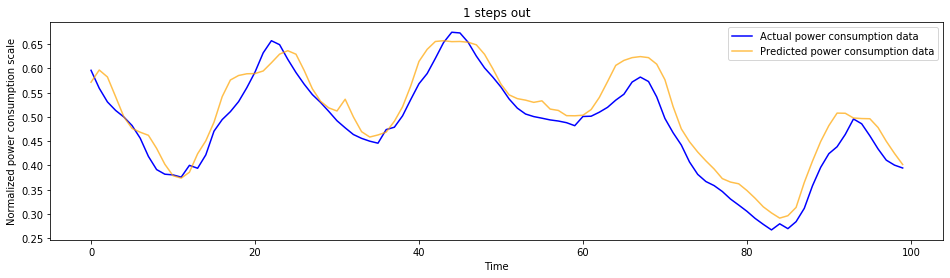

MSE for 1 timesteps ahead: 38.63668231591232


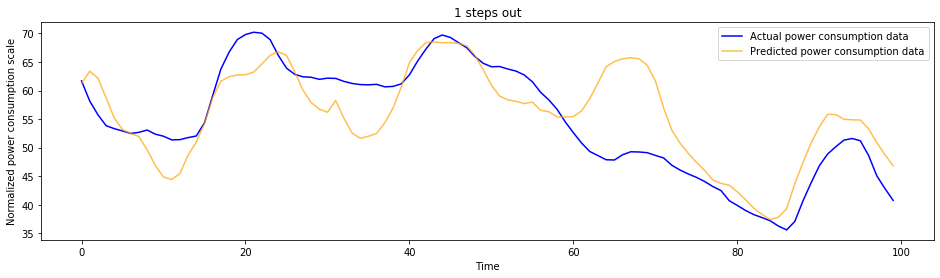

MSE for 2 timesteps ahead: 0.03287799298763275


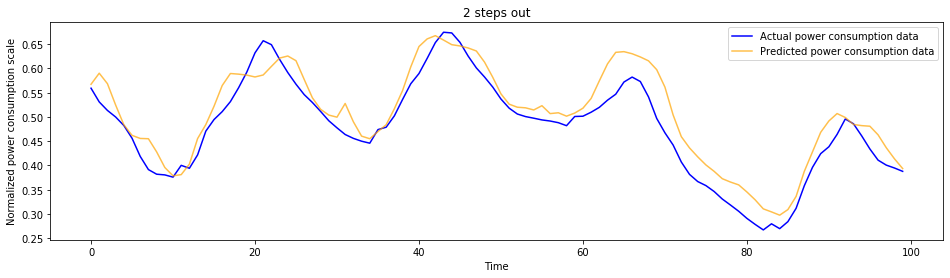

MSE for 2 timesteps ahead: 42.97810981915907


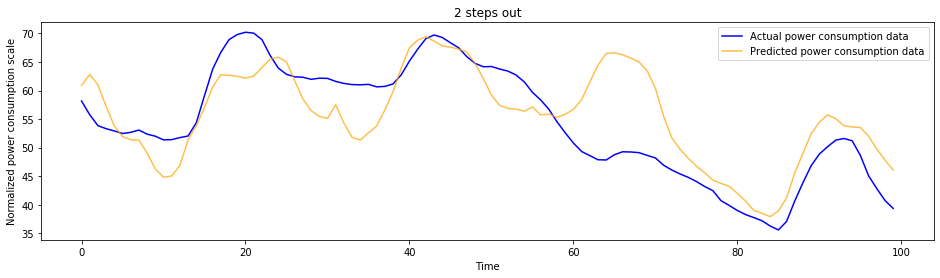

MSE for 3 timesteps ahead: 0.035927439332008364


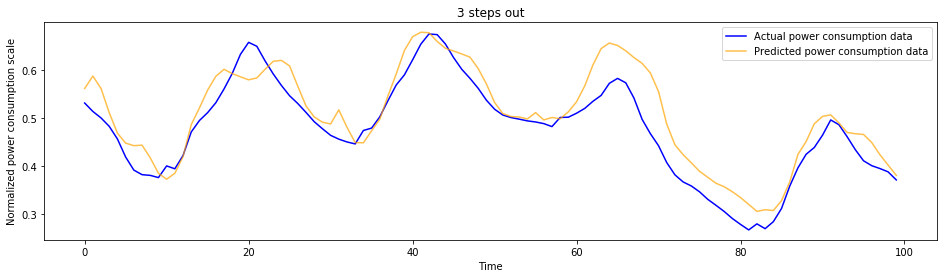

MSE for 3 timesteps ahead: 49.52407784241411


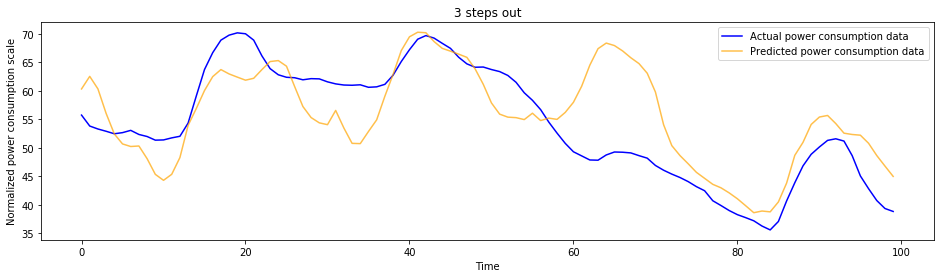

MSE for 4 timesteps ahead: 0.04167711347341538


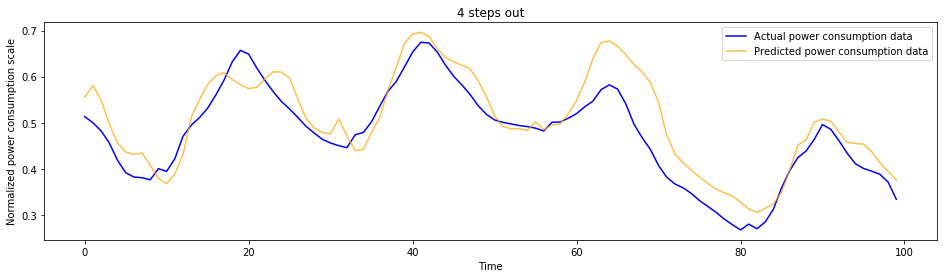

MSE for 4 timesteps ahead: 56.41466076945757


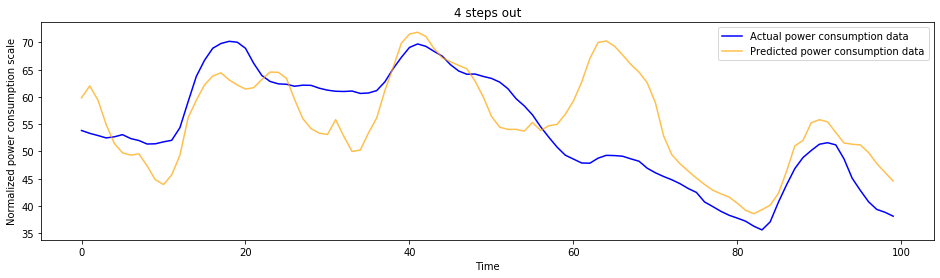

In [64]:
#test...hopefully can delete
for i in range(yhat_unNormal.shape[1]):
    mse=mean_absolute_error(y_test[:,i], yhat[:,i])
    print("MSE for {} timesteps ahead:".format(i+1),mse)
    plot_predictions(y_test[:,i], yhat[:,i], "{} steps out".format(i+1))
    mse=mean_squared_error(results['Temp_True'][i:tp+i].values, yhat_unNormal[:,i])
    print("MSE for {} timesteps ahead:".format(i+1),mse)
    plot_predictions(results['Temp_True'][i:tp+i].values, yhat_unNormal[:,i], "{} steps out".format(i+1))

In [44]:
#test. can delete hoepuflly

#need to set horizon correctly so the shape of the results and the yhat values can correspond. 
#if horizion 
for i in range(yhat_unNormal.shape[1]):
    index=yhat_unNormal.shape[1]-i-1
    mse=mean_squared_error(results['Temp_True'][(yhat_unNormal.shape[1]-1)-i:results.shape[0]-i].values, yhat_unNormal[(yhat_unNormal.shape[1]-1)-i:results.shape[0]-i,index])
    print("MSE for {} timesteps ahead:".format(index+1),mse)
    plot_predictions(results['Temp_True'][(yhat_unNormal.shape[1]-1)-i:results.shape[0]-i].values, yhat_unNormal[:,index], "{} steps out".format(index+1))

ValueError: Found input variables with inconsistent numbers of samples: [8761, 8755]

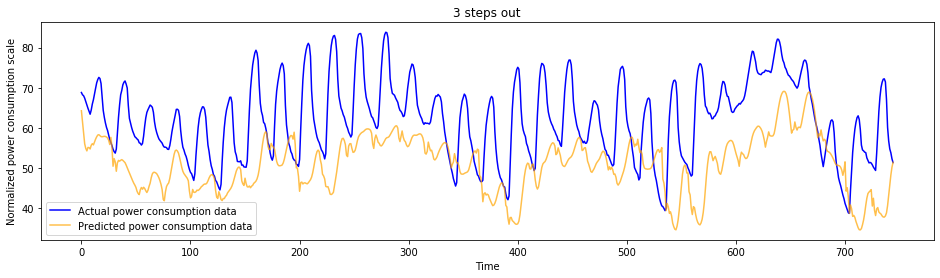

In [414]:
plot_predictions(results['Temp_True'][2-0:results.shape[0]-0].values, yhat_unNormal[:,2], "3 steps out")

In [409]:
mse=mean_squared_error(results['Temp_True'][2-1:results.shape[0]-1].values, yhat_unNormal[:,1])
mse

231.62030914128187

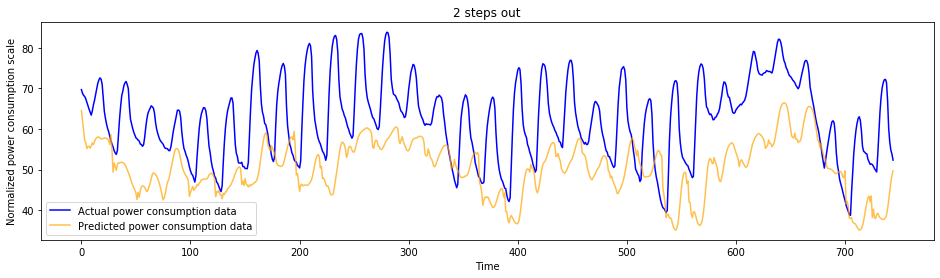

In [410]:
plot_predictions(results['Temp_True'][2-1:results.shape[0]-1].values, yhat_unNormal[:,1], "2 steps out")

In [411]:
mse=mean_squared_error(results['Temp_True'][2-2:results.shape[0]-2].values, yhat_unNormal[:,0])
mse

224.65972853940272

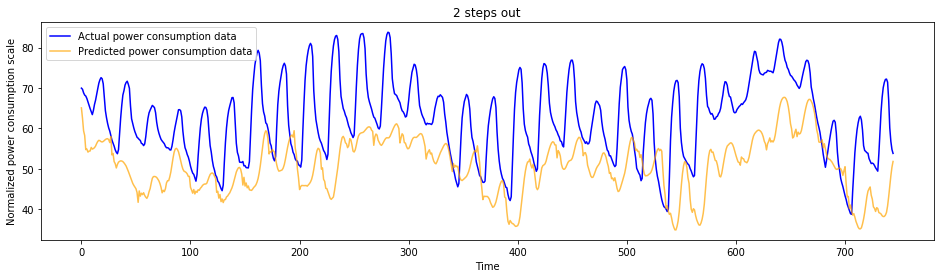

In [412]:
plot_predictions(results['Temp_True'][2-2:results.shape[0]-2].values, yhat_unNormal[:,0], "2 steps out")

In [298]:
rmse = math.sqrt(mean_squared_error(results['Temp_True'].values,T_values[scaled.shape[0]-744:scaled.shape[0],0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.646


In [299]:
rnn_score = r2_score(results['Temp_True'].values, T_values[scaled.shape[0]-744:scaled.shape[0],0])
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.37321908627637645


In [241]:
#scaled.iloc[t:scaled.shape[0],0]=yhat[:,0]
T_values=scaler.inverse_transform(scaled)


In [242]:
T_values[t:scaled.shape[0],0].shape

(744,)

In [369]:
t_scaler = MinMaxScaler(feature_range=(0, 1))
test=np.array(Xw_train['Avg_Temp']).reshape(-1,1)
t_scaled = t_scaler.fit_transform(test)

In [370]:
yhatvalues=yhatvalues.reshape(-1,1)
true_yhat=t_scaler.inverse_transform(yhatvalues)


In [282]:
plot_predictions(results['True_Temp'].values, T_values[t:scaled.shape[0],0], "Predictions made by simple RNN model")

KeyError: 'True_Temp'

In [323]:
#drop nan values from full_data for load model
load_data=full_data.dropna()
#create load data with temp to fit model
load_length=load_data.shape[0]
load_values=load_data.LOAD.values
w=load_data.drop(['ZONEID', 'TIMESTAMP','LOAD'],axis=1)
mw=w.mean(axis=1)
dti_l = pd.date_range('2005-01-01 01:00', periods=load_length, freq='H')
load_df=pd.DataFrame({'LOAD': load_values,'temp':mw.values, 'index': dti_l})
load_df=load_df.set_index('index')

In [324]:
load_df

,LOAD,temp
index,,
2005-01-01 01:00:00,125.8,46.20
2005-01-01 02:00:00,121.8,46.00
2005-01-01 03:00:00,117.0,45.08
2005-01-01 04:00:00,114.4,45.24
2005-01-01 05:00:00,113.6,44.80
...,...,...
2010-12-31 20:00:00,188.1,43.56
2010-12-31 21:00:00,187.6,42.04
2010-12-31 22:00:00,184.1,41.16


In [329]:
Xl_train= create_features(load_df,kind='load', label='LOAD')

In [330]:
Xl_train

,LOAD,weekday,year,dayofyear,hour,month,dayofweek,quarter,dayofmonth,weekofyear,temp
index,,,,,,,,,,,
2005-01-01 01:00:00,125.8,1,2005,1,1,1,5,1,1,53,46.20
2005-01-01 02:00:00,121.8,1,2005,1,2,1,5,1,1,53,46.00
2005-01-01 03:00:00,117.0,1,2005,1,3,1,5,1,1,53,45.08
2005-01-01 04:00:00,114.4,1,2005,1,4,1,5,1,1,53,45.24
2005-01-01 05:00:00,113.6,1,2005,1,5,1,5,1,1,53,44.80
...,...,...,...,...,...,...,...,...,...,...,...
2010-12-31 20:00:00,188.1,0,2010,365,20,12,4,4,31,52,43.56
2010-12-31 21:00:00,187.6,0,2010,365,21,12,4,4,31,52,42.04
2010-12-31 22:00:00,184.1,0,2010,365,22,12,4,4,31,52,41.16


In [331]:
# load dataset
l_values = Xl_train.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
l_values = l_values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
l_scaled = scaler.fit_transform(l_values)
l_scaled=pd.DataFrame(l_scaled)
l_scaled

,0,1,2,3,4,5,6,7,8,9,10
0,0.289671,1.0,0.000000,0.00000,0.043478,0.0,0.833333,0.0,0.0,1.000000,0.394638
1,0.274701,1.0,0.000000,0.00000,0.086957,0.0,0.833333,0.0,0.0,1.000000,0.392286
2,0.256737,1.0,0.000000,0.00000,0.130435,0.0,0.833333,0.0,0.0,1.000000,0.381468
3,0.247006,1.0,0.000000,0.00000,0.173913,0.0,0.833333,0.0,0.0,1.000000,0.383349
4,0.244012,1.0,0.000000,0.00000,0.217391,0.0,0.833333,0.0,0.0,1.000000,0.378175
...,...,...,...,...,...,...,...,...,...,...,...
52579,0.522829,0.0,0.833313,0.99726,0.869565,1.0,0.666667,1.0,1.0,0.980769,0.363594
52580,0.520958,0.0,0.833313,0.99726,0.913043,1.0,0.666667,1.0,1.0,0.980769,0.345720
52581,0.507859,0.0,0.833313,0.99726,0.956522,1.0,0.666667,1.0,1.0,0.980769,0.335372
52582,0.485778,0.0,0.833313,0.99726,1.000000,1.0,0.666667,1.0,1.0,0.980769,0.333960


In [334]:
#create train, test data
l_seq_len = 100 #choose sequence length
l_train_length=l_scaled.shape[0]-ps-l_seq_len
Xl_train, yl_train, Xl_test, yl_test = load_data(l_scaled, l_seq_len,l_train_length)

print('Xl_train.shape = ',Xl_train.shape)
print('yl_train.shape = ', yl_train.shape)
print('Xl_test.shape = ', Xl_test.shape)
print('yl_test.shape = ',yl_test.shape)

Xl_train.shape =  (51740, 100, 11)
yl_train.shape =  (51740,)
Xl_test.shape =  (744, 100, 11)
yl_test.shape =  (744,)


In [335]:
l_rnn_model = Sequential()

l_rnn_model.add(SimpleRNN(60,activation="tanh",return_sequences=True, input_shape=(Xl_train.shape[1],Xl_train.shape[2])))
l_rnn_model.add(Dropout(0.25))

l_rnn_model.add(SimpleRNN(60,activation="tanh",return_sequences=True))
l_rnn_model.add(Dropout(0.35))

l_rnn_model.add(SimpleRNN(60,activation="tanh",return_sequences=False))
l_rnn_model.add(Dropout(0.15))

l_rnn_model.add(Dense(1))

l_rnn_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_34 (SimpleRNN)    (None, 100, 60)           4320      
_________________________________________________________________
dropout_34 (Dropout)         (None, 100, 60)           0         
_________________________________________________________________
simple_rnn_35 (SimpleRNN)    (None, 100, 60)           7260      
_________________________________________________________________
dropout_35 (Dropout)         (None, 100, 60)           0         
_________________________________________________________________
simple_rnn_36 (SimpleRNN)    (None, 60)                7260      
_________________________________________________________________
dropout_36 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

Train on 51740 samples, validate on 744 samples
Epoch 1/100
 - 29s - loss: 0.3311 - val_loss: 0.0197
Epoch 2/100
 - 28s - loss: 0.1436 - val_loss: 0.0167
Epoch 3/100
 - 28s - loss: 0.0991 - val_loss: 0.0096
Epoch 4/100
 - 28s - loss: 0.0764 - val_loss: 0.0105
Epoch 5/100
 - 27s - loss: 0.0586 - val_loss: 0.0090
Epoch 6/100
 - 27s - loss: 0.0478 - val_loss: 0.0097
Epoch 7/100
 - 27s - loss: 0.0407 - val_loss: 0.0068
Epoch 8/100
 - 27s - loss: 0.0313 - val_loss: 0.0071
Epoch 9/100
 - 27s - loss: 0.0258 - val_loss: 0.0073
Epoch 10/100
 - 27s - loss: 0.0225 - val_loss: 0.0059
Epoch 11/100
 - 27s - loss: 0.0199 - val_loss: 0.0041
Epoch 12/100
 - 27s - loss: 0.0170 - val_loss: 0.0041
Epoch 13/100
 - 27s - loss: 0.0148 - val_loss: 0.0035
Epoch 14/100
 - 28s - loss: 0.0126 - val_loss: 0.0051
Epoch 15/100
 - 28s - loss: 0.0123 - val_loss: 0.0029
Epoch 16/100
 - 27s - loss: 0.0103 - val_loss: 0.0034
Epoch 17/100
 - 27s - loss: 0.0096 - val_loss: 0.0039
Epoch 18/100
 - 27s - loss: 0.0088 - val_lo

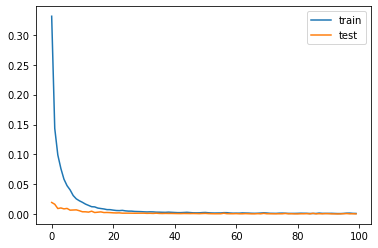

In [336]:
l_rnn_model.compile(optimizer="adam",loss="MSE")
history=l_rnn_model.fit(Xl_train, yl_train, epochs=100, batch_size=1000, validation_data=(Xl_test, yl_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [337]:
Xl_test.shape

(744, 100, 11)

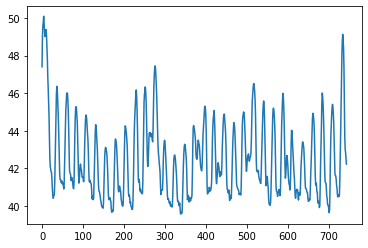

In [338]:
plt.plot(true_yhat)

In [339]:
lyhat=[]
lfirst="yes"
for i in range(Xl_test.shape[0]):
    if(lfirst=="yes"):
        lpred1=np.array(Xl_test[i,:,:])
        lpred1=lpred1.reshape((1, Xl_test.shape[1], Xl_test.shape[2]))
        lytemp=l_rnn_model.predict(lpred1)
        lyhat.append(lytemp)
        lfirst="no"
    else:
        Xl_test[i,-1,0]=lytemp
        Xl_test[i,-1,-1]=true_yhat[i]
        lpred=np.array(Xl_test[i,:,:])
        lpred=lpred.reshape((1, Xl_test.shape[1], Xl_test.shape[2]))
        lytemp=l_rnn_model.predict(lpred)
        lyhat.append(lytemp) 

In [340]:
lyhatvalues=np.array(lyhat)
lyhatvalues=lyhatvalues.reshape(lyhatvalues.shape[0])
lyhatvalues=lyhatvalues

In [341]:
rmse = math.sqrt(mean_squared_error(yl_test,lyhatvalues))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.408


In [342]:
rnn_score = r2_score(yl_test,lyhatvalues)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  -7.028597129967341


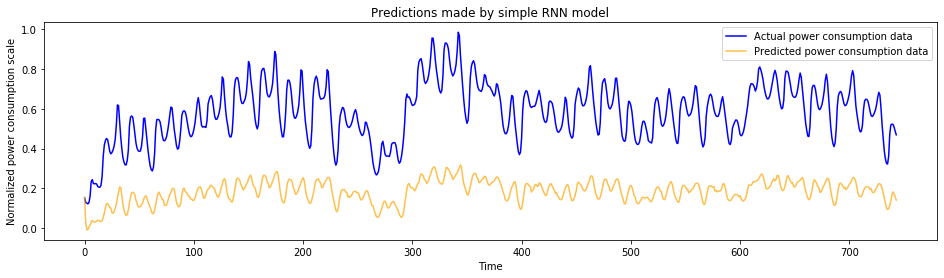

In [343]:
plot_predictions(yl_test, lyhatvalues, "Predictions made by simple RNN model")

In [344]:
lt_scaler = MinMaxScaler(feature_range=(0, 1))
ltest=np.array(results['True_Load']).reshape(-1,1)
lt_scaled = lt_scaler.fit_transform(ltest)

In [345]:
lyhatvalues=lyhatvalues.reshape(-1,1)
ltrue_yhat=lt_scaler.inverse_transform(lyhatvalues)



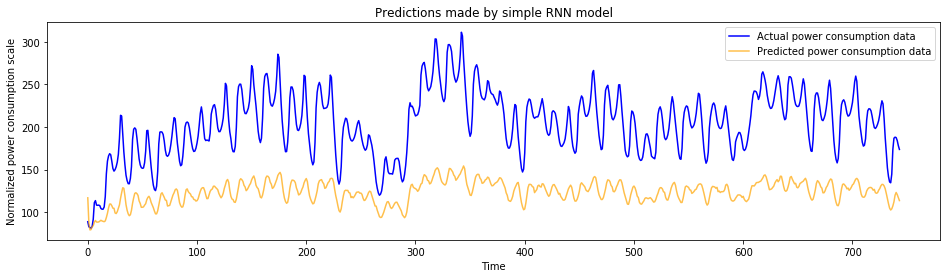

In [346]:
plot_predictions(ltest, ltrue_yhat, "Predictions made by simple RNN model")